<a href="https://colab.research.google.com/github/adikalamaro/repo2/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  #install kaggle

!pip install -q kaggle

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import to_categorical, plot_model
import numpy
from numpy import argmax
from numpy import mean
from numpy import std
from numpy import expand_dims
from sklearn.metrics import accuracy_score
from keras.datasets.cifar10 import load_data
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import keras.backend as K

In [2]:
!pip install tensorflow keras

# **Importing Dataset**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from  google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [5]:
!chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [13]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"adikal2001","key":"7572ae2fa0c6527ccdb258f7172b2b3e"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

 99% 310M/312M [00:14<00:00, 24.4MB/s]
100% 312M/312M [00:14<00:00, 22.1MB/s]


In [15]:
!unzip brain-tumor-segmentation.zip

Archive:  brain-tumor-segmentation.zip
replace images/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

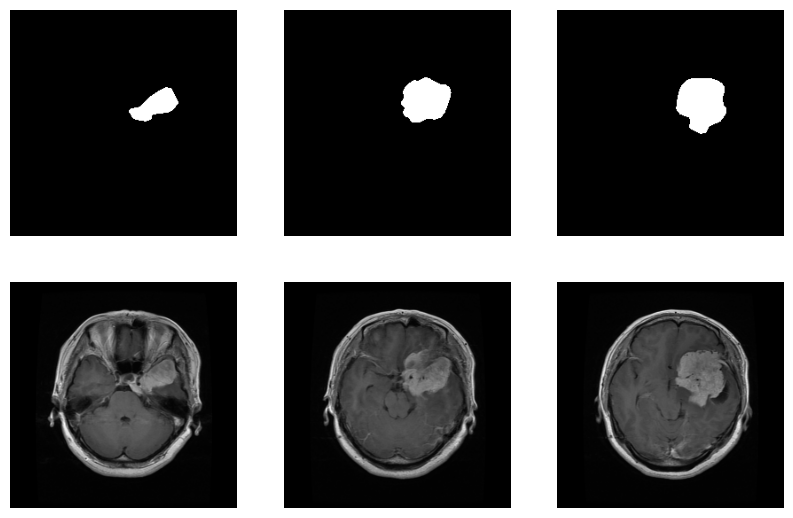

In [16]:

SIZE_X = 256
SIZE_Y = 256
images = []
masks = []

for i in range(1, 3064):
    # Construct the image and mask file paths based on the number 'i'

    image_filename = f'{i}.png'
    mask_filename = f'{i}.png'

    imagePath = os.path.join('images', image_filename)
    img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.uint8)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = cv2.merge([img, img, img])
    images.append(img)

    maskPath = os.path.join('masks', mask_filename)
    mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    mask = mask / 255
    mask = mask.astype(np.uint8)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

n_samples = 3
plt.figure(figsize = (10, 10))
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap = 'gray')
# plot target image
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(images[i], cmap = 'gray')
plt.show()

# **Preprocessing**

In [17]:
y = np.expand_dims(masks, axis = 3)
print(y.shape)

(3063, 256, 256, 1)


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)

[0 1]
(3063, 256, 256)


In [19]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
print(train_masks_input.shape)

(3063, 256, 256, 1)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input,
                                                    test_size = 0.2, shuffle = True, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.2, random_state = 42)

from tensorflow.keras.utils import to_categorical
n_classes = 2
train_masks_cat = to_categorical(y_train, num_classes = n_classes)
test_masks_cat = to_categorical(y_test, num_classes = n_classes)
val_masks_cat = to_categorical(y_val, num_classes = n_classes)

print(f'TRAIN SET:\n'
     f'X_train shape: {X_train.shape}\n'
     f'y_train shape: {train_masks_cat.shape}\n\n'
     f'VALIDATION SET:\n'
     f'X_val shape: {X_val.shape}\n'
     f'y_val shape: {val_masks_cat.shape}\n\n'
     f'TEST SET:\n'
     f'X_test shape: {X_test.shape}\n'
     f'y_test shape: {test_masks_cat.shape}')

TRAIN SET:
X_train shape: (1960, 256, 256, 3)
y_train shape: (1960, 256, 256, 2)

VALIDATION SET:
X_val shape: (490, 256, 256, 3)
y_val shape: (490, 256, 256, 2)

TEST SET:
X_test shape: (613, 256, 256, 3)
y_test shape: (613, 256, 256, 2)


# **Unet model**

In [21]:
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding = "same")(x)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x

In [22]:

LR = 0.001  # Learning rate
optimizer = Adam(LR)  # Optimizer
activation = 'sigmoid'  # Activation function for the output layer
loss = 'binary_crossentropy'  # Loss function

# Metrics: Dice coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2  # Classes: tumor and background
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

metrics = [dice_coef]
img_size = (256, 256, 3)  # Image dimensions

def build_unet_model(img_size, num_classes):
    # Input
    inputs = Input(shape=img_size)
    # Encoder
    # 1 - Downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - Downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - Downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - Downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - Bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # Decoder
    # 6 - Upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - Upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - Upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - Upsample
    u9 = upsample_block(u8, f1, 64)
    # Output
    outputs = Conv2D(num_classes, 1, padding="same", activation=activation)(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model


In [23]:
K.clear_session()

unet_model = build_unet_model(img_size, n_classes)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

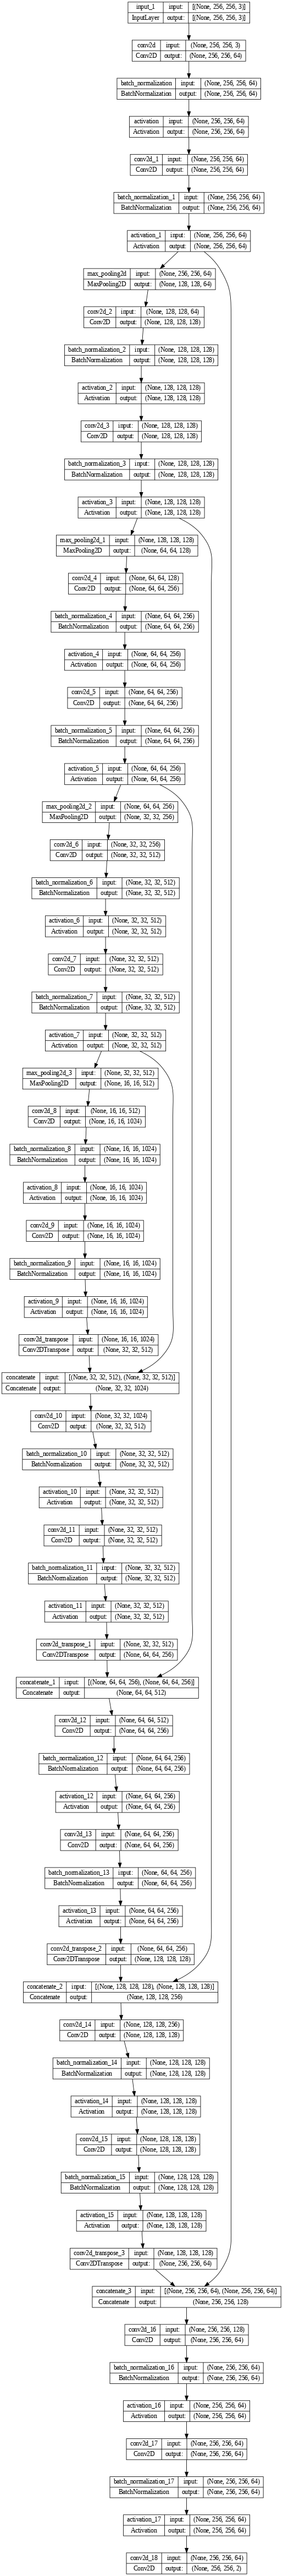

In [24]:
plot_model(unet_model, show_shapes = True, show_layer_names = True, dpi = 60)


In [25]:
unet_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

earlystopper = EarlyStopping(patience = 5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = '/kaggle/working/checkpoint.hdf5',
                               verbose = 1,
                               save_best_only = True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 0.001,
                              verbose = 1,  cooldown = 1)

history = unet_model.fit(X_train, train_masks_cat, batch_size = 32, epochs = 15, verbose = 1,
                        shuffle = True, callbacks = [earlystopper, checkpointer, reduce_lr],
                        validation_data = (X_val, val_masks_cat))

Epoch 1/15
62/62 [==============================] - ETA: 0s - loss: 0.1971 - dice_coef: 0.4753
Epoch 1: val_loss improved from inf to 885.22473, saving model to /kaggle/working/checkpoint.hdf5
62/62 [==============================] - 220s 2s/step - loss: 0.1971 - dice_coef: 0.4753 - val_loss: 885.2247 - val_dice_coef: 0.4197 - lr: 0.0010
Epoch 2/15
62/62 [==============================] - ETA: 0s - loss: 0.0915 - dice_coef: 0.5141
Epoch 2: val_loss improved from 885.22473 to 0.28337, saving model to /kaggle/working/checkpoint.hdf5
62/62 [==============================] - 130s 2s/step - loss: 0.0915 - dice_coef: 0.5141 - val_loss: 0.2834 - val_dice_coef: 0.4827 - lr: 0.0010
Epoch 3/15
62/62 [==============================] - ETA: 0s - loss: 0.0679 - dice_coef: 0.5576
Epoch 3: val_loss improved from 0.28337 to 0.10755, saving model to /kaggle/working/checkpoint.hdf5
62/62 [==============================] - 130s 2s/step - loss: 0.0679 - dice_coef: 0.5576 - val_loss: 0.1076 - val_dice_coef

In [26]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['dice_coef']
    val_acc = history.history['val_dice_coef']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)

    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train','Val'])
    plt.title('Training and validation loss')

    plt.show()

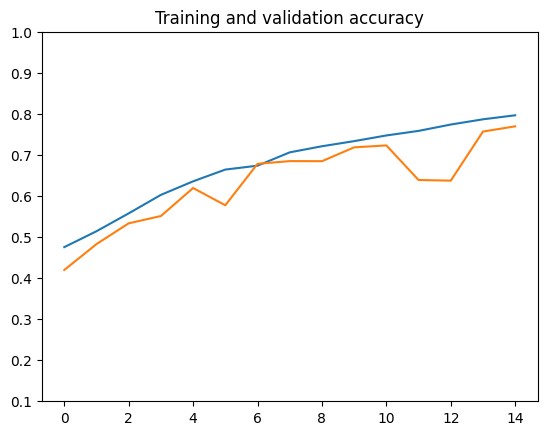

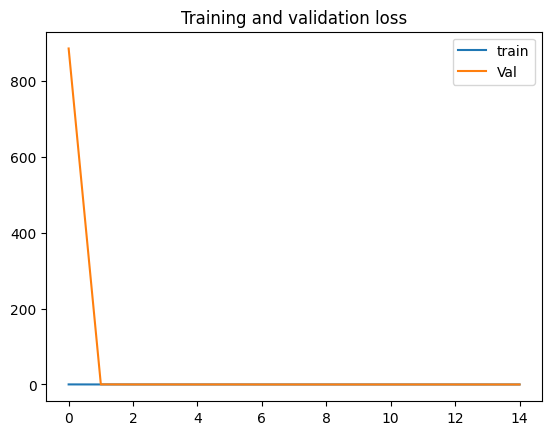

In [27]:
plot_history(history, (0.1,1))

In [28]:
unet_model.save('trained_unet_model.h5')

In [29]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 99% 86.0M/86.8M [00:05<00:00, 22.6MB/s]
100% 86.8M/86.8M [00:05<00:00, 16.9MB/s]


In [30]:
!unzip brain-tumor-classification-mri

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [31]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Define metric function
def dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

# Register the custom metric function
custom_objects = {'dice_coef': dice_coef}

# Load the model using the custom_objects parameter
model = load_model('trained_unet_model.h5', custom_objects=custom_objects)


In [32]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [33]:
X = []
y = []
image_size = 256

# Iterate over the files in the folder
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)  # Append the image array to the list of images
        y.append(i) # Append label name

# Iterate over the files in the folder
for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X.append(img)
        y.append(i)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

100%|██████████| 74/74 [00:00<00:00, 189.79it/s]


In [34]:
def visualize_prediction(original_image, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots

    # Display original image on the left subplot
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Process predicted mask for visualization
    threshold = 0.02  # Adjust threshold as needed
    binary_mask = (predicted_mask[..., 1] > threshold).astype(int)

    # Display predicted mask on the middle subplot (binary mask)
    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title('Predicted Binary Mask')
    axes[1].axis('off')

    # Display predicted mask on the right subplot (probability map)
    axes[2].imshow(predicted_mask[..., 1], cmap='jet', alpha=0.7)
    axes[2].set_title('Predicted Probability Map')
    axes[2].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Show the figure

# # Assuming you have 'X' as your original images and 'predicted_masks' as the predicted masks
# for i in range(4):
#     visualize_prediction(X[i], predicted_masks[i])


102/102 [==============================] - 56s 552ms/step


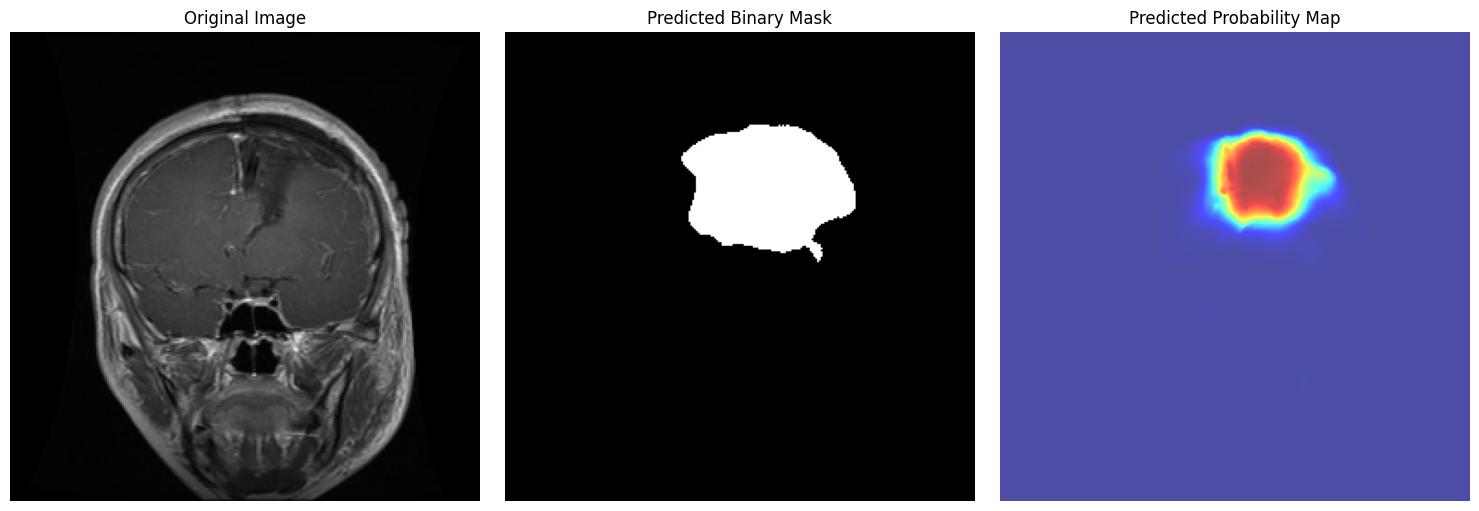

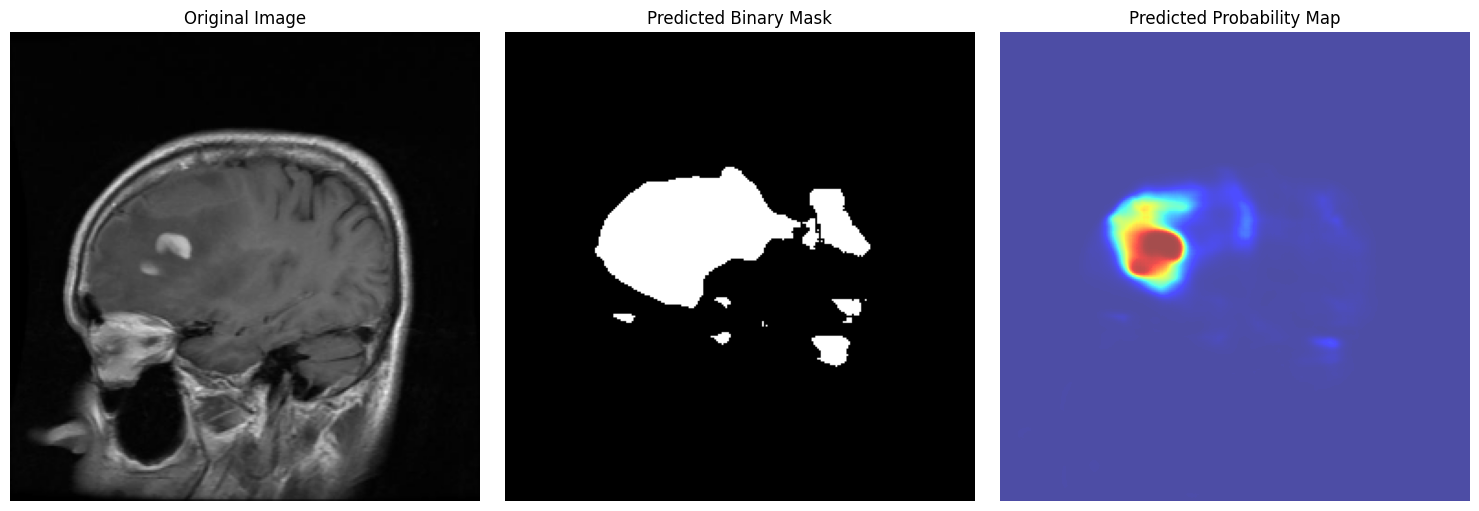

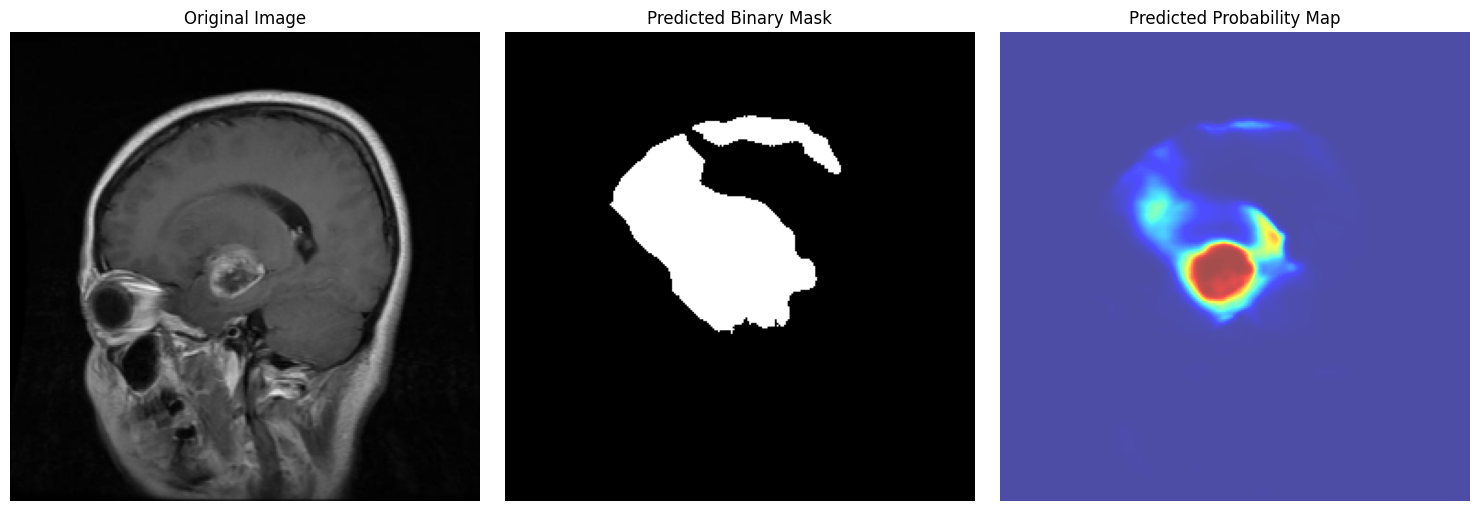

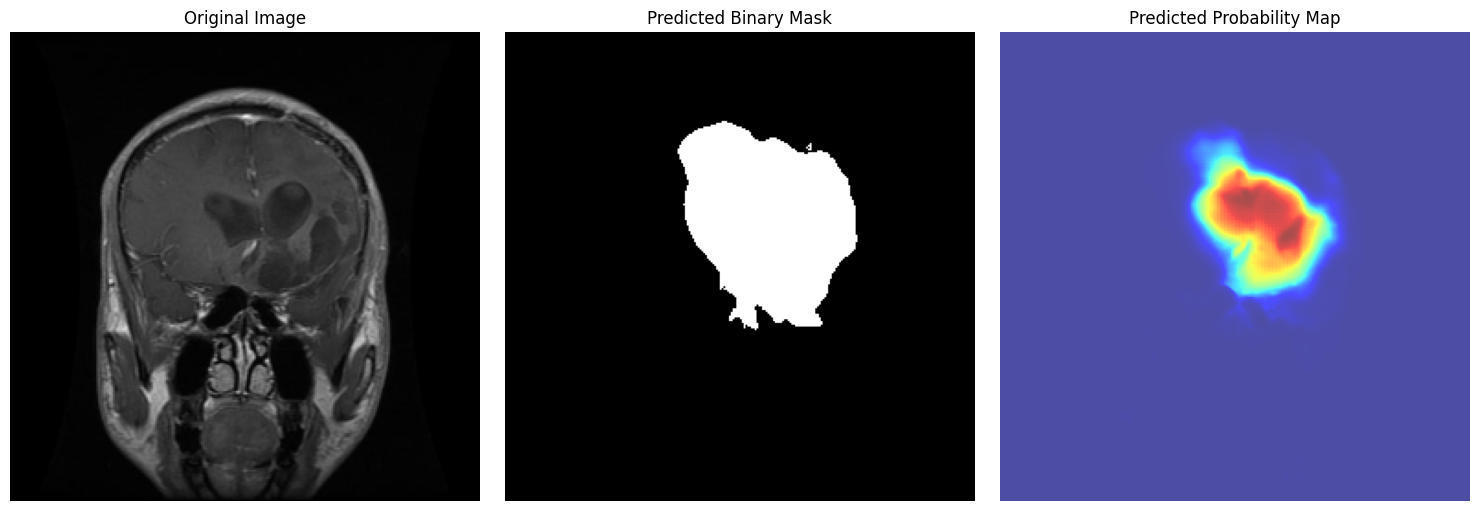

In [68]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image


# Predict masks for the new images
predicted_masks = model.predict(X)

# Post-process predicted masks if needed

# Visualize results
for i in range(4):
    visualize_prediction(X[i], predicted_masks[i])


In [69]:
predicted_masks.shape

(3264, 256, 256, 2)

In [70]:
Xn = predicted_masks

In [71]:
# Split the dataset into training and test sets
X2_train, X2_test, y2_train,y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Split the dataset into training and test sets
Xn_train, Xn_test, yn_train,yn_test = train_test_split(Xn, y, test_size=0.2, random_state=42)

In [73]:
Xn_train = Xn_train.astype('float32')
Xn_test = Xn_test.astype('float32')
# X_val= X_val.astype('float32')

In [74]:
# We want the values to be between 0 to 1

Xn_train = Xn_train/255
Xn_test = Xn_test/255
# X_val = X_val/255

In [75]:
yn_train = yn_train.reshape(-1, 1)  # Reshape to a column vector
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(yn_train)
yn_train = one_hot_encoder.transform(yn_train).toarray()

In [76]:
yn_test = yn_test.reshape(-1, 1)  # Reshape to a column vector
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(yn_test)
yn_test = one_hot_encoder.transform(yn_test).toarray()

In [77]:
import tensorflow as tf

# Assuming you have loaded your images and labels into X_train and y_train

# Resize images to (224, 224)
Xn_train_resized = tf.image.resize(Xn_train, (224, 224))
Xn_test_resized = tf.image.resize(Xn_test, (224, 224))

# Convert image datatype to float32
Xn_train_resized = tf.cast(Xn_train_resized, tf.float32)
Xn_test_resized = tf.cast(Xn_test_resized, tf.float32)

# Perform per-image standardization (subtract mean and divide by standard deviation)
Xn_train_resized = tf.image.per_image_standardization(Xn_train_resized)
Xn_test_resized = tf.image.per_image_standardization(Xn_test_resized)

# Check the shape of the resized images
print("Training images shape:", Xn_train_resized.shape)  # (num_samples, 224, 224, 3)


Training images shape: (2611, 224, 224, 2)


In [86]:
import tensorflow as tf
import numpy as np
import torch

X2_train = torch.tensor(X2_train, dtype=torch.float32)
# Assuming Xn_train_resized is a TensorFlow tensor
numpy_array = Xn_train_resized.numpy()  # Convert TensorFlow tensor to NumPy array
Xn_train_resized = torch.tensor(numpy_array, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor

<ipython-input-86-910167c9715e>:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, NumClasses, UseGPU=True):
        super(Net, self).__init__()
        self.UseGPU = UseGPU
        self.Net = models.resnet50(pretrained=True)
        self.Net.fc = nn.Linear(2048, NumClasses)
        self.AttentionLayer = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=True)
        self.AttentionLayer.bias.data = torch.ones(self.AttentionLayer.bias.data.shape)
        self.AttentionLayer.weight.data = torch.zeros(self.AttentionLayer.weight.data.shape)

    def forward(self, Images, ROI):
        InpImages = torch.autograd.Variable(Images, requires_grad=False)
        ROIMap = torch.autograd.Variable(ROI, requires_grad=False).unsqueeze(dim=1)

        if self.UseGPU:
            InpImages = InpImages.cuda()
            ROIMap = ROIMap.cuda()

        RGBMean = [123.68, 116.779, 103.939]
        RGBStd = [65, 65, 65]
        for i in range(len(RGBMean)):
            InpImages[:, i, :, :] = (InpImages[:, i, :, :] - RGBMean[i]) / RGBStd[i]

        x = self.Net.conv1(InpImages)
        AttentionMap = self.AttentionLayer(F.interpolate(ROIMap, size=x.shape[2:4], mode='bilinear'))
        x = x + AttentionMap

        x = self.Net.bn1(x)
        x = self.Net.relu(x)
        x = self.Net.maxpool(x)
        x = self.Net.layer1(x)
        x = self.Net.layer2(x)
        x = self.Net.layer3(x)
        x = self.Net.layer4(x)
        x = torch.mean(torch.mean(x, dim=2), dim=2)
        x = self.Net.fc(x)
        ProbVec = F.softmax(x, dim=1)
        Prob, Pred = ProbVec.max(dim=1)

        return ProbVec, Pred

# Create an instance of the network
num_classes = 4
net = Net(num_classes)

# Example usage:
# Replace `Images` and `ROI` with your actual data
# Images should be a tensor of shape (batch_size, channels, height, width)
# ROI should be a tensor of shape (batch_size, height, width)
# The values of ROI should indicate the regions of interest (tumor areas) in the images
images = X2_train # Replace with your actual images
roi = Xn_train_resized # Replace with your actual ROI masks

# Perform inference
with torch.no_grad():
    probabilities, predictions = net(images, roi)

print("Class Probabilities:", probabilities)
print("Predicted Classes:", predictions)


OutOfMemoryError: ignored

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model (without the top classifier)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze some layers
for layer in base_model.layers[:10]:
    layer.trainable = False

# Replace the classifier
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the modified model
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
def define_model():
    model = tf.keras.Sequential()

    # Convolutional layers with increased filters and kernel size
    model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(256, 256, 2)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Flatten the feature maps
    model.add(layers.Flatten())

    # Fully connected layers with increased units
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer for multi-class classification
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model=define_model()

In [ ]:

# Set batch size and number of epochs
batch_size = 32
epochs = 10

# Train your model using the fit method
model.fit(
    Xn_train, yn_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1
)

Epoch 1/10
74/74 [==============================] - 15s 132ms/step - loss: 1.3706 - accuracy: 0.2742 - val_loss: 1.3636 - val_accuracy: 0.2710
Epoch 2/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3619 - accuracy: 0.2929 - val_loss: 1.3558 - val_accuracy: 0.3321
Epoch 3/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3624 - accuracy: 0.2886 - val_loss: 1.3605 - val_accuracy: 0.2443
Epoch 4/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3610 - accuracy: 0.2827 - val_loss: 1.3565 - val_accuracy: 0.2710
Epoch 5/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3608 - accuracy: 0.2840 - val_loss: 1.3583 - val_accuracy: 0.2710
Epoch 6/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3591 - accuracy: 0.2869 - val_loss: 1.3562 - val_accuracy: 0.3321
Epoch 7/10
74/74 [==============================] - 8s 108ms/step - loss: 1.3594 - accuracy: 0.2912 - val_loss: 1.3557 - val_accuracy: 0.3321
Epoch

In [64]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)

    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['Val','Train'])
    plt.title('Training and validation loss')

    plt.show()

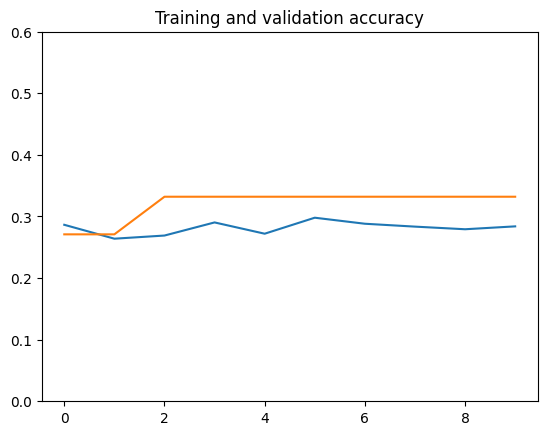

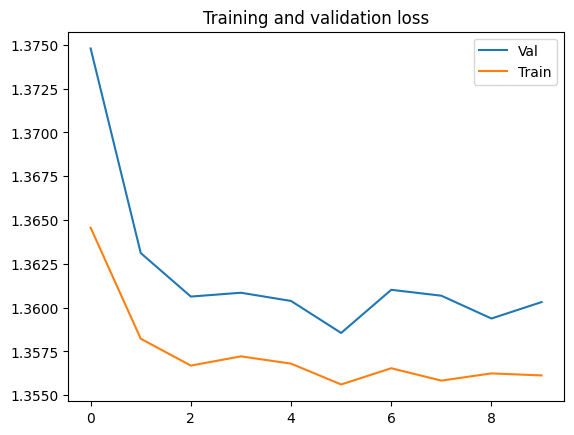

In [65]:
plot_history(history1,(0,0.6))